In [25]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks, butter, filtfilt, freqz
from scipy.stats import zscore
from scipy.interpolate import interp2d
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from skimage.segmentation import watershed
import umap

### Stages of classical spike soritng
Traditionally spike sorting was divided into four steps:

1. **Preprocessing of extracellular trace:** Raw extracellular recordings contain low frequency (less than ~200 Hz) activity 'local field potentials', higher frequency noise (greater than ~6 kHz), and action potential related signals (between 300 and 6000Hz). Removal of shared noise or correlations across electrodes can also be performed.
2. **Detection of spiking events:** Spiking events are detected as deviations from the recording 'noise' and snippets of waveforms around these points are taken for later clustering. Several different detection strategies can be used, with some differences between detection on single and multi-electrode recordings.
3. **Dimensionality reduction of spike waveforms:** We want to identify features in the spike waveforms that can be used for sorting them. One can use hand-crafted features (e.g. amplitude, spike-width), or automated approaches to derive features. These feature spaces can be thought of as dimensionality reduction, which enhances our ability to visualize clusters of similar spike waveforms and makes the subsequent clustering process less computationally expensive.
4. **Clustering of spike groups:** Often the feature space will contain several groupings of spike waveforms. One can place the borders between these manually, or use unsupervised clustering algorithms.

We will consider each of these steps. At each stage, multiple options will be given so if you want you can create your own simple spike sorting algorithm!

### Loading recording data
Extracellular field potential (voltage) recordings are often saved as binary files. Binary files are a list of numbers with a length equal to the *number of channels* **X** *number of time samples*. Each number has a format, most often a signed 16 bit integer for neural recordings. Information about the number of channels, time points, and data format are stored in a separate file (sometimes referred to as a meta file because it has meta information, i.e. information about your information). Most of the time, data is ordered first by channel, then by time, resulting in a format of: 
| Data |
| --- |
| ch1_t1 | 
| ch2_t1 |
| ch3_t1 |
| ... |
| chN_t1 | 
| ch1_t2 | 
| ch2_t2 | 
| ch3_t2 |
| ... |
| chN_tM |

In total, we have *N* channels and *M* time points. If each number is a 16 bit integer, than each is 2 bytes, which means the total file size will be *N* **X** *M* **X** 2. I have included some sample data to practice sorting on. Let's see what its file size is.

In [2]:
# Get the number of bytes of the binary file
bin_sz = os.stat('../Data/TestRecording.bin')
print("The binary file is {x} bytes in length".format(x=bin_sz.st_size))

The binary file is 24000016 bytes in length


This file is a snippet of data from a much longer Neuropixel probe recording. I know that I selected 8 adjacent channels on the probe, but I don't remember how many time points there were. To get the number of time points, we can take the number of bytes and divide by *N channels* **X** *bytes per sample*. We have 8 channels and each data point/sample has 2 bytes.

In [3]:
# Calculate number of time points
chan_num = 8
tpt_num = bin_sz.st_size/(chan_num*2)
print("The number of time points is {x}".format(x=tpt_num))
tpt_num = int(tpt_num)

The number of time points is 1500001.0


We have 1,500,001 time points. You want this to be a whole number, since we cannot have fractional data points. If we do not get a whole number from this calculation, then either we are wrong about the number of channels or the number of bytes per sample.

Dividing the number of samples by the sample rate per second we get duration of our recording in seconds.

In [4]:
# Determine how long our recording is
samp_rate = 30000 # Hz, samples per second
print("The recording duration is {x} seconds".format(x=tpt_num/samp_rate))

The recording duration is 50.000033333333334 seconds


Now let's read in the data. Since our file is small, only 24 MB, we will read it all into our workspace as a numpy array. When dealing with *real* data that can be tens to hundreds of GB in size you will use memory mapping or chunking. We won't worry about that here.

In [5]:
# Read in our binary data into a numpy array
rec_raw = np.fromfile('../Data/TestRecording.bin',np.int16)

# Rearrange the data from a list to a matrix, with time points along the rows and channels along the columns
rec_raw = np.reshape(rec_raw,(int(tpt_num),chan_num))

Now we will plot the data to make sure everything is formatted correctly. It is best to only plot a short segment of time, a few 10s of milliseconds, since plotting the entire recording would take a long time and be difficult to individual spikes.

Text(0.5, 1.0, 'Raw recording')

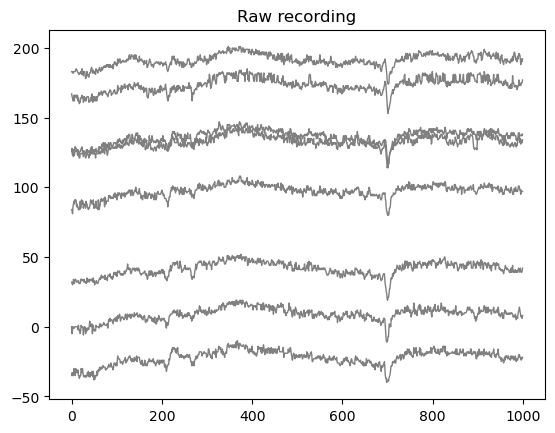

In [6]:
# defining a plotting function since we will do a lot of plotting
def SnipPlot(r1=[],r2=[],win=[0,1000]):
    if len(r1)!=0:
        ax = sns.lineplot(data=r1[win[0]:win[1],:]+np.arange(0,chan_num)*30,
                          legend=False, linewidth=1)
        for x in range(chan_num):
            ax.lines[x].set_color([0.5, 0.5, 0.5])
    else:
        ax = []

    if len(r2)!=0:
        if not ax:
            ax = sns.lineplot(data=r2[win[0]:win[1],:]+np.arange(0,chan_num)*30,
                              palette='flare',legend=False, linewidth=2)
        else:
            ax = sns.lineplot(data=r2[win[0]:win[1],:]+np.arange(0,chan_num)*30,
                              palette='flare',legend=False, linewidth=2, ax=ax)
    
    for x in range(len(ax.lines)):
        ax.lines[x].set_linestyle('-')
    
    return ax

SnipPlot(r1=rec_raw,r2=[]).set_title('Raw recording')

### Preprocessing
The raw signal has several problems. First, each channel has a different voltage offset from 0 (known as a DC component). This is evident in the overlapping of some of the traces even though they are separated in the plot. Second, there are slow fluctuations in the signal that are comparable in amplitude in the spikes and will 

#### Removal of DC and filtering

Text(0.5, 1.0, 'DC offset removed recording data compared with raw signal')

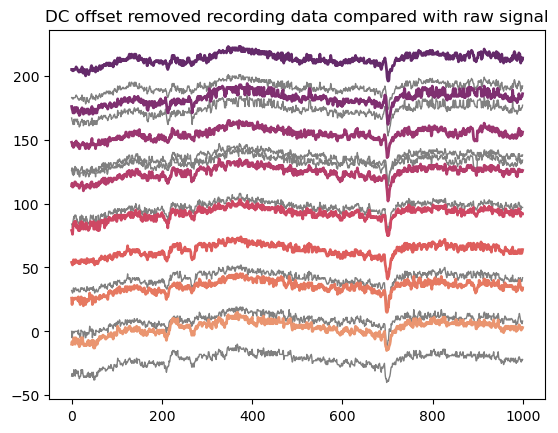

In [8]:
# just removed the DC offset from the raw signal
rec_nodc = rec_raw - np.median(rec_raw,axis=0).reshape((1,-1))

SnipPlot(r1=rec_raw,r2=rec_nodc).set_title('DC offset removed recording data compared with raw signal')

#### Filtering in the spikes frequency band

Text(0, 0.5, 'Magnitude')

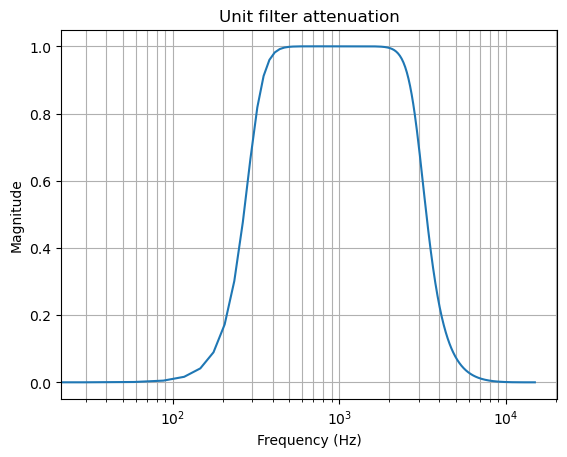

In [9]:
# Define frequency passband in Hz
f_order = 4
f_pass = [300, 3000]

# Create filter and display its properties
b, a = butter(f_order, f_pass, 'bandpass', fs=samp_rate)
w, h = freqz(b,a,fs=samp_rate)
ax = sns.lineplot(x=w,y=np.abs(h))
ax.set(xscale='log')
ax.grid(True,which='both')
ax.set_title('Unit filter attenuation')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')

Text(0.5, 1.0, 'Filtered recording data compared with no DC signal')

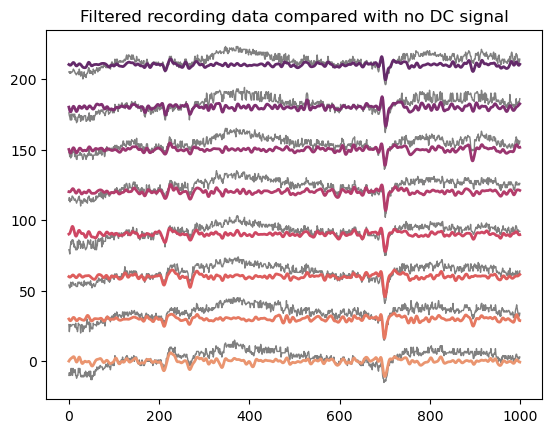

In [10]:
# filter the signals to remove the DC, low frequency LFP, and high frequency noise
rec_filt = filtfilt(b,a,rec_raw.T).T

# plot filtered signal over DC offset removed signal
SnipPlot(r1=rec_nodc,r2=rec_filt).set_title('Filtered recording data compared with no DC signal')

#### Common average referencing

Text(0.5, 1.0, 'Common average reference subtracted compared with filtered recording data')

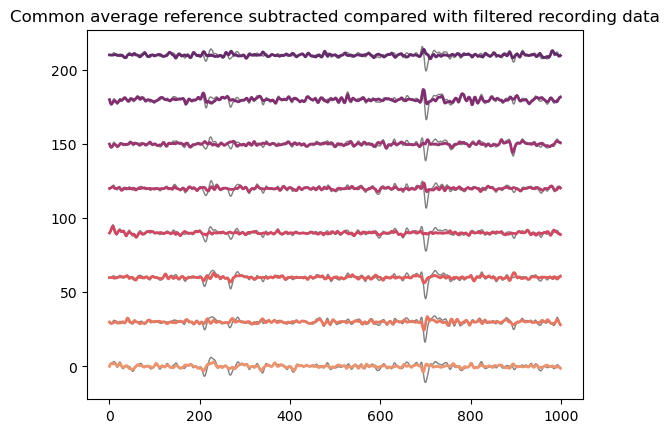

In [11]:
# remove median (common) signal across electrodes
rec_car = rec_filt - np.median(rec_filt,axis=1).reshape((-1,1))

# plot filtered signal with common average reference removed
SnipPlot(r1=rec_filt,r2=rec_car).set_title('Common average reference subtracted compared with filtered recording data')

#### Whitening

### Spike detection

Once the recording has been processed to accenuate spikes, we need to detect them. Several different approaches have been proposed for doing this. This depends on whether you have just one or multiple electrodes, how close those electrodes are to each other, whether you know their spatial arrangement, how you define the noise level, etc. 

#### Simple thresold detection 

In [12]:
# define peak conditions
z_thresh = 2 # minimum peak height
min_dist = 30 # minimum distance between peaks, at 30kHz sample rate this is 1ms

# z-score transform each channel so that the same threshold can be used across all of them
rec_z = zscore(rec_filt,axis=0)

# identify peaks on each channel that exceed the z threshold
spks_all = [find_peaks(np.abs(x.squeeze()), distance=min_dist, height=z_thresh)[0] for x in np.hsplit(rec_z,chan_num)]

We can check our spike detection performance by plotting spike times on top of recordings.

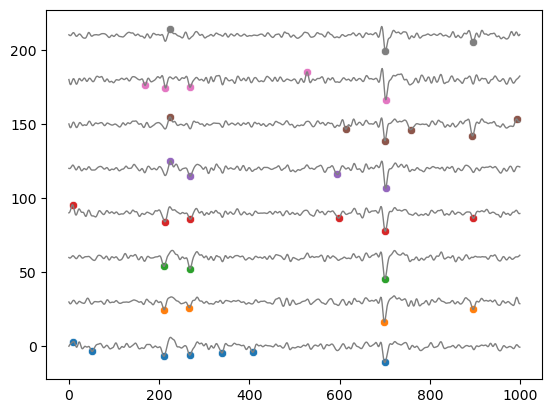

In [13]:
def SnipSpksPlot(rec=[],spk=[],win=[0,1000]):
    ax = SnipPlot(r1=rec,win=win)
    for chan,x in enumerate(spk):
        spk_sub = x[np.where((x>=win[0])&(x<=win[1]))]
        peak_vals = rec[spk_sub,chan] + chan*30
        sns.scatterplot(x=spk_sub-win[0],y=peak_vals,ax=ax)

SnipSpksPlot(rec_filt,spks_all)

Since this is a multichannel recording, we want to combine the spike times across all electrodes. The simplest way to do this is to pool them all together and remove duplicates. This works here because generally if a spike is detected on multiple channels it reflects the same neuron. However, if we were using a larger array of electrodes where difference units could be detected simultaneously then this approach would not work.

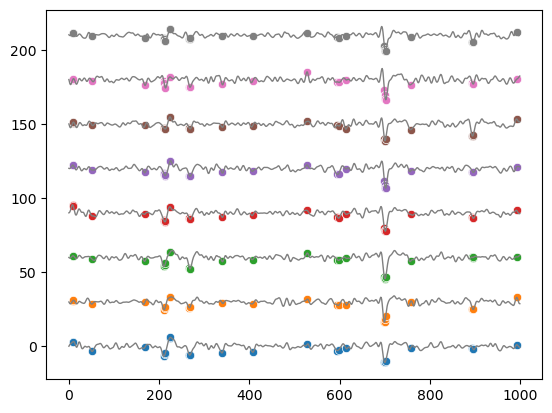

In [14]:
# pool spike times and remove duplicates
spks_pooled = np.unique(np.hstack(spks_all))

# plot again to verify that merging was successful
SnipSpksPlot(rec=rec_filt,spk=[spks_pooled]*chan_num)

Uh, oh! It looks like we are getting multiple detections for the same spikes. You can see this best with the prominent spike around time step 700.

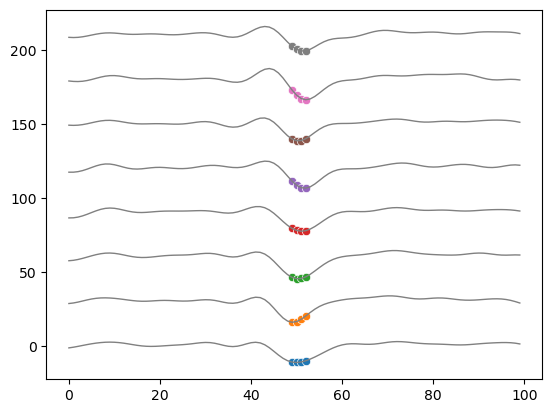

In [15]:
SnipSpksPlot(rec=rec_filt, spk=[spks_pooled]*chan_num,win=[650, 750])

We can deal with this by identifying the spike time that has the strongest amplitude, and removing the other spike times that are within the minimum spacing we defined already. The quick-n-dirty algorithm below does this.

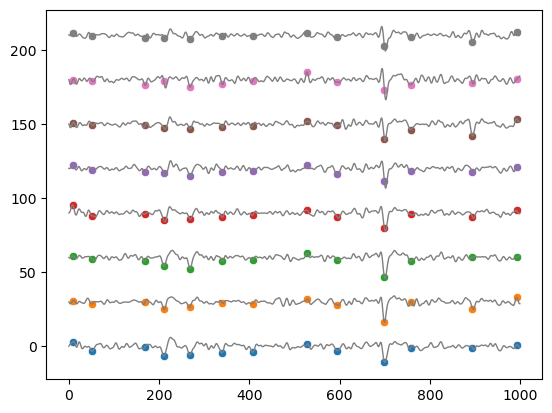

In [16]:
# For each spike time, get its peak amplitude across all channels
spks_amp = np.abs(rec_z[spks_pooled,:]).max(1)
spks_num = len(spks_pooled)

# Here is a simple algorithm to remove redundant spikes
spks_keep = [False]*spks_num # list of spikes to keep, initially we don't keep any
ind = 0
while (ind < spks_num): # step through our spike list
    spk_curr = spks_pooled[ind] # get current spike index
    spk_near_inds = np.where((spks_pooled[ind:]-spk_curr)<=min_dist)[0] # find spikes within our original min distance
    max_ind = np.argmax(spks_amp[ind + np.arange(spk_near_inds.size)]) # get index of redundant spike with largest amplitude
    spks_keep[ind+max_ind] = True # keep the spike
    ind+=spk_near_inds.size # move along to next spike that is not redundant

# Get the final list of spikes with redundant ones removed
spks_simp = spks_pooled[spks_keep]

# plot again to verify that redundant spikes were removed and only kept largest amplitude ones
SnipSpksPlot(rec=rec_filt,spk=[spks_simp]*chan_num)

#### Overall energy across electrodes

<AxesSubplot: >

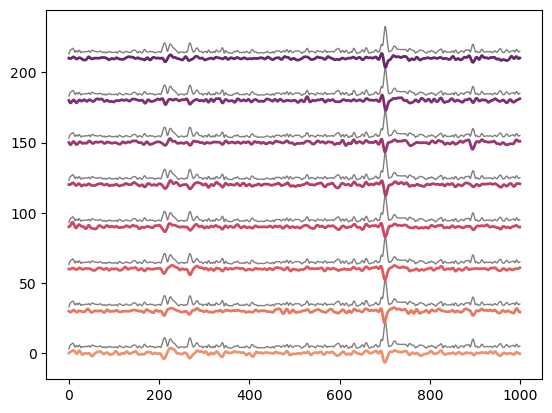

In [17]:
# define peak conditions
z_thresh = 2 # minimum peak height
min_dist = 30 # minimum distance between peaks, at 30kHz sample rate this is 1ms

# z-score transform each channel so it is easier to compare results with simple method
rec_z = zscore(rec_filt,axis=0)

# get overall amplitude across electrodes
rec_zn = np.linalg.norm(rec_z,axis=1) # calculates Frobenius norm (essentially euclidian distance of each time point)

# compare the mean signal with those from each channel
SnipPlot(r1=np.tile(rec_zn.reshape(-1,1),(1,chan_num))+3, r2=rec_z)


We can detect spikes on just the single derived norm trace, eliminating the problem of harmonizing redundant spikes across electrodes.

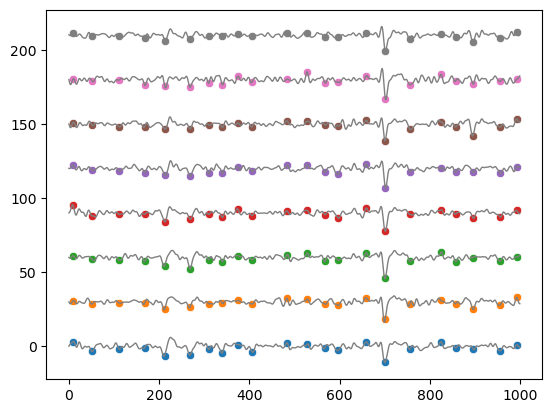

In [18]:
# identify peaks
spks_norm = find_peaks(rec_zn, distance=min_dist, height=z_thresh)[0]

# plot again to verify that redundant spikes were removed and only kept largest amplitude ones
SnipSpksPlot(rec=rec_filt,spk=[spks_norm]*chan_num)

#### Watershed detection

In [46]:
# define peak conditions
z_thresh = 2 # minimum peak height
min_dist = 30 # minimum distance between peaks, at 30kHz sample rate this is 1ms

# z-score transform each channel so it is easier to compare results with simple method
rec_z = zscore(rec_filt,axis=0)

chan_x = [0, 2, 1, 3, 0, 2, 1, 3]
chan_y = [0, 0, 1, 1, 2, 2, 3, 3]

inp_x, inp_y = np.meshgrid(range(4),range(4))

rec_spa = np.zeros((4,4,tpt_num))

for x in range(tpt_num):
    inp_func = interp2d(chan_x,chan_y,rec_z[x,:].squeeze())
    inp_temp = inp_func(range(4),range(4))
    rec_spa[:,:,x] = inp_temp

### Dimensionality reduction of spike waveforms

Once we have identified the spikes, we want to assign them to different neurons based on their waveform shape. Each neuron near our electrode will produce a different waveform shape due to its morphology and positiion relative to the array of electrodes. Trying to manually assign each waveform to a particular neuron is impractical, both because of the enormous number of spikes and the difficulty of comparing waveforms across many electrodes. To get a sense of the challenge, look at the waveforms below.

In [21]:
# Select spike time source
spks = spks_simp

# Spike waveform extraction parameters
win_start = -10
win_end = 20
win_inds = range(win_start,win_end)
win_num = len(win_inds)
spks_num = spks.size

# preallocate waveform array
waves = np.zeros((spks_num, win_num, chan_num))

# remove spikes whose waveform window will overlap with the edges of the recording
spks = spks[np.where((spks>(-win_start))&(spks<(tpt_num-win_end)))]

# reshape our rec to make waveform extraction simpler
rec = rec_z.T

# Extract spike waveforms 
for ind,spk_curr in enumerate(spks):
    waves[ind,:,:] = rec[:,spk_curr+win_inds].T.reshape((win_num,chan_num))


To make sure our waveforms look right, we will plot a few. Each line is a different spike, with the waveform tiled aross all channels. Thus, the length of the line will be *number of waveform samples* **X** *number of channels*. Here we will just plot two waveforms that are obviously distinct.

<AxesSubplot: >

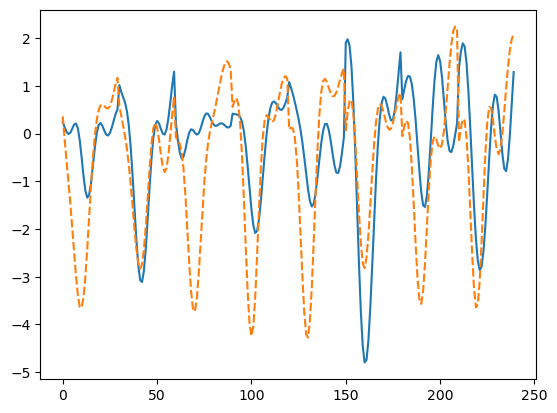

In [134]:
sns.lineplot(waves[(10,21),:].T.reshape(-1,2),legend=False)

As you can see, the waveforms are different from these two units. One of them shows the spike waveform spanning all recording electrodes, with peaks on each electrode. The other is more heterogenous in its expression across the channels, with only 3 channels showing prominent spike waveforms.

If we now plot just 10, the variability across waveforms makes it harder to see the differences.

<AxesSubplot: >

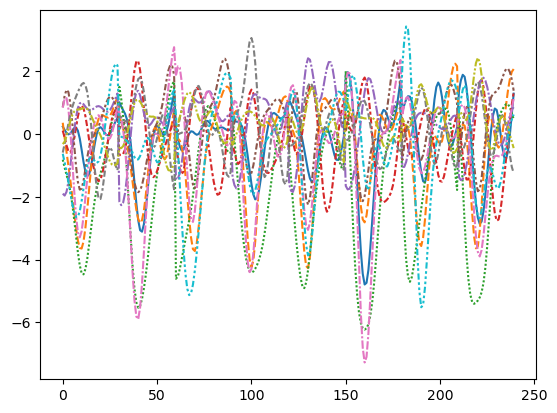

In [135]:
sns.lineplot(waves[(10,21,24,27,29,34,38,40,50,60),:].T.reshape(-1,10),legend=False)

To make visualization of waveform differences more obvious, we can try to identify a smaller set of features that capture differences in the waveform shape.

#### Hand crafted features
There are numerous simple features one can extract from each spike waveform. A one is the peak (positive or negative) of the spike wave across channels. More complicated measures would be the duration of the spike, ascending or descending slope, or strength of secondary peaks.

The simplest way to get the waveform peak is to just sample the voltage at each channel at the time the spike was detected. A problem with this approach is that the spike may peak at slightly different times on different electrodes. For this demo, we will neglect this problem.

In [136]:
# extract peak voltages
waves_peak = waves[:,-win_start,:].squeeze()

This gives us as many dimensions as there are channels. If you have more than 3 dimensions, visualization can be tricky. One easy way to visualize a high dimensional space is to create a grid of plots with each showing the data from a different vantage point. A pair plot is one way to do this. It creates a scater plot for each pair of dimensions.

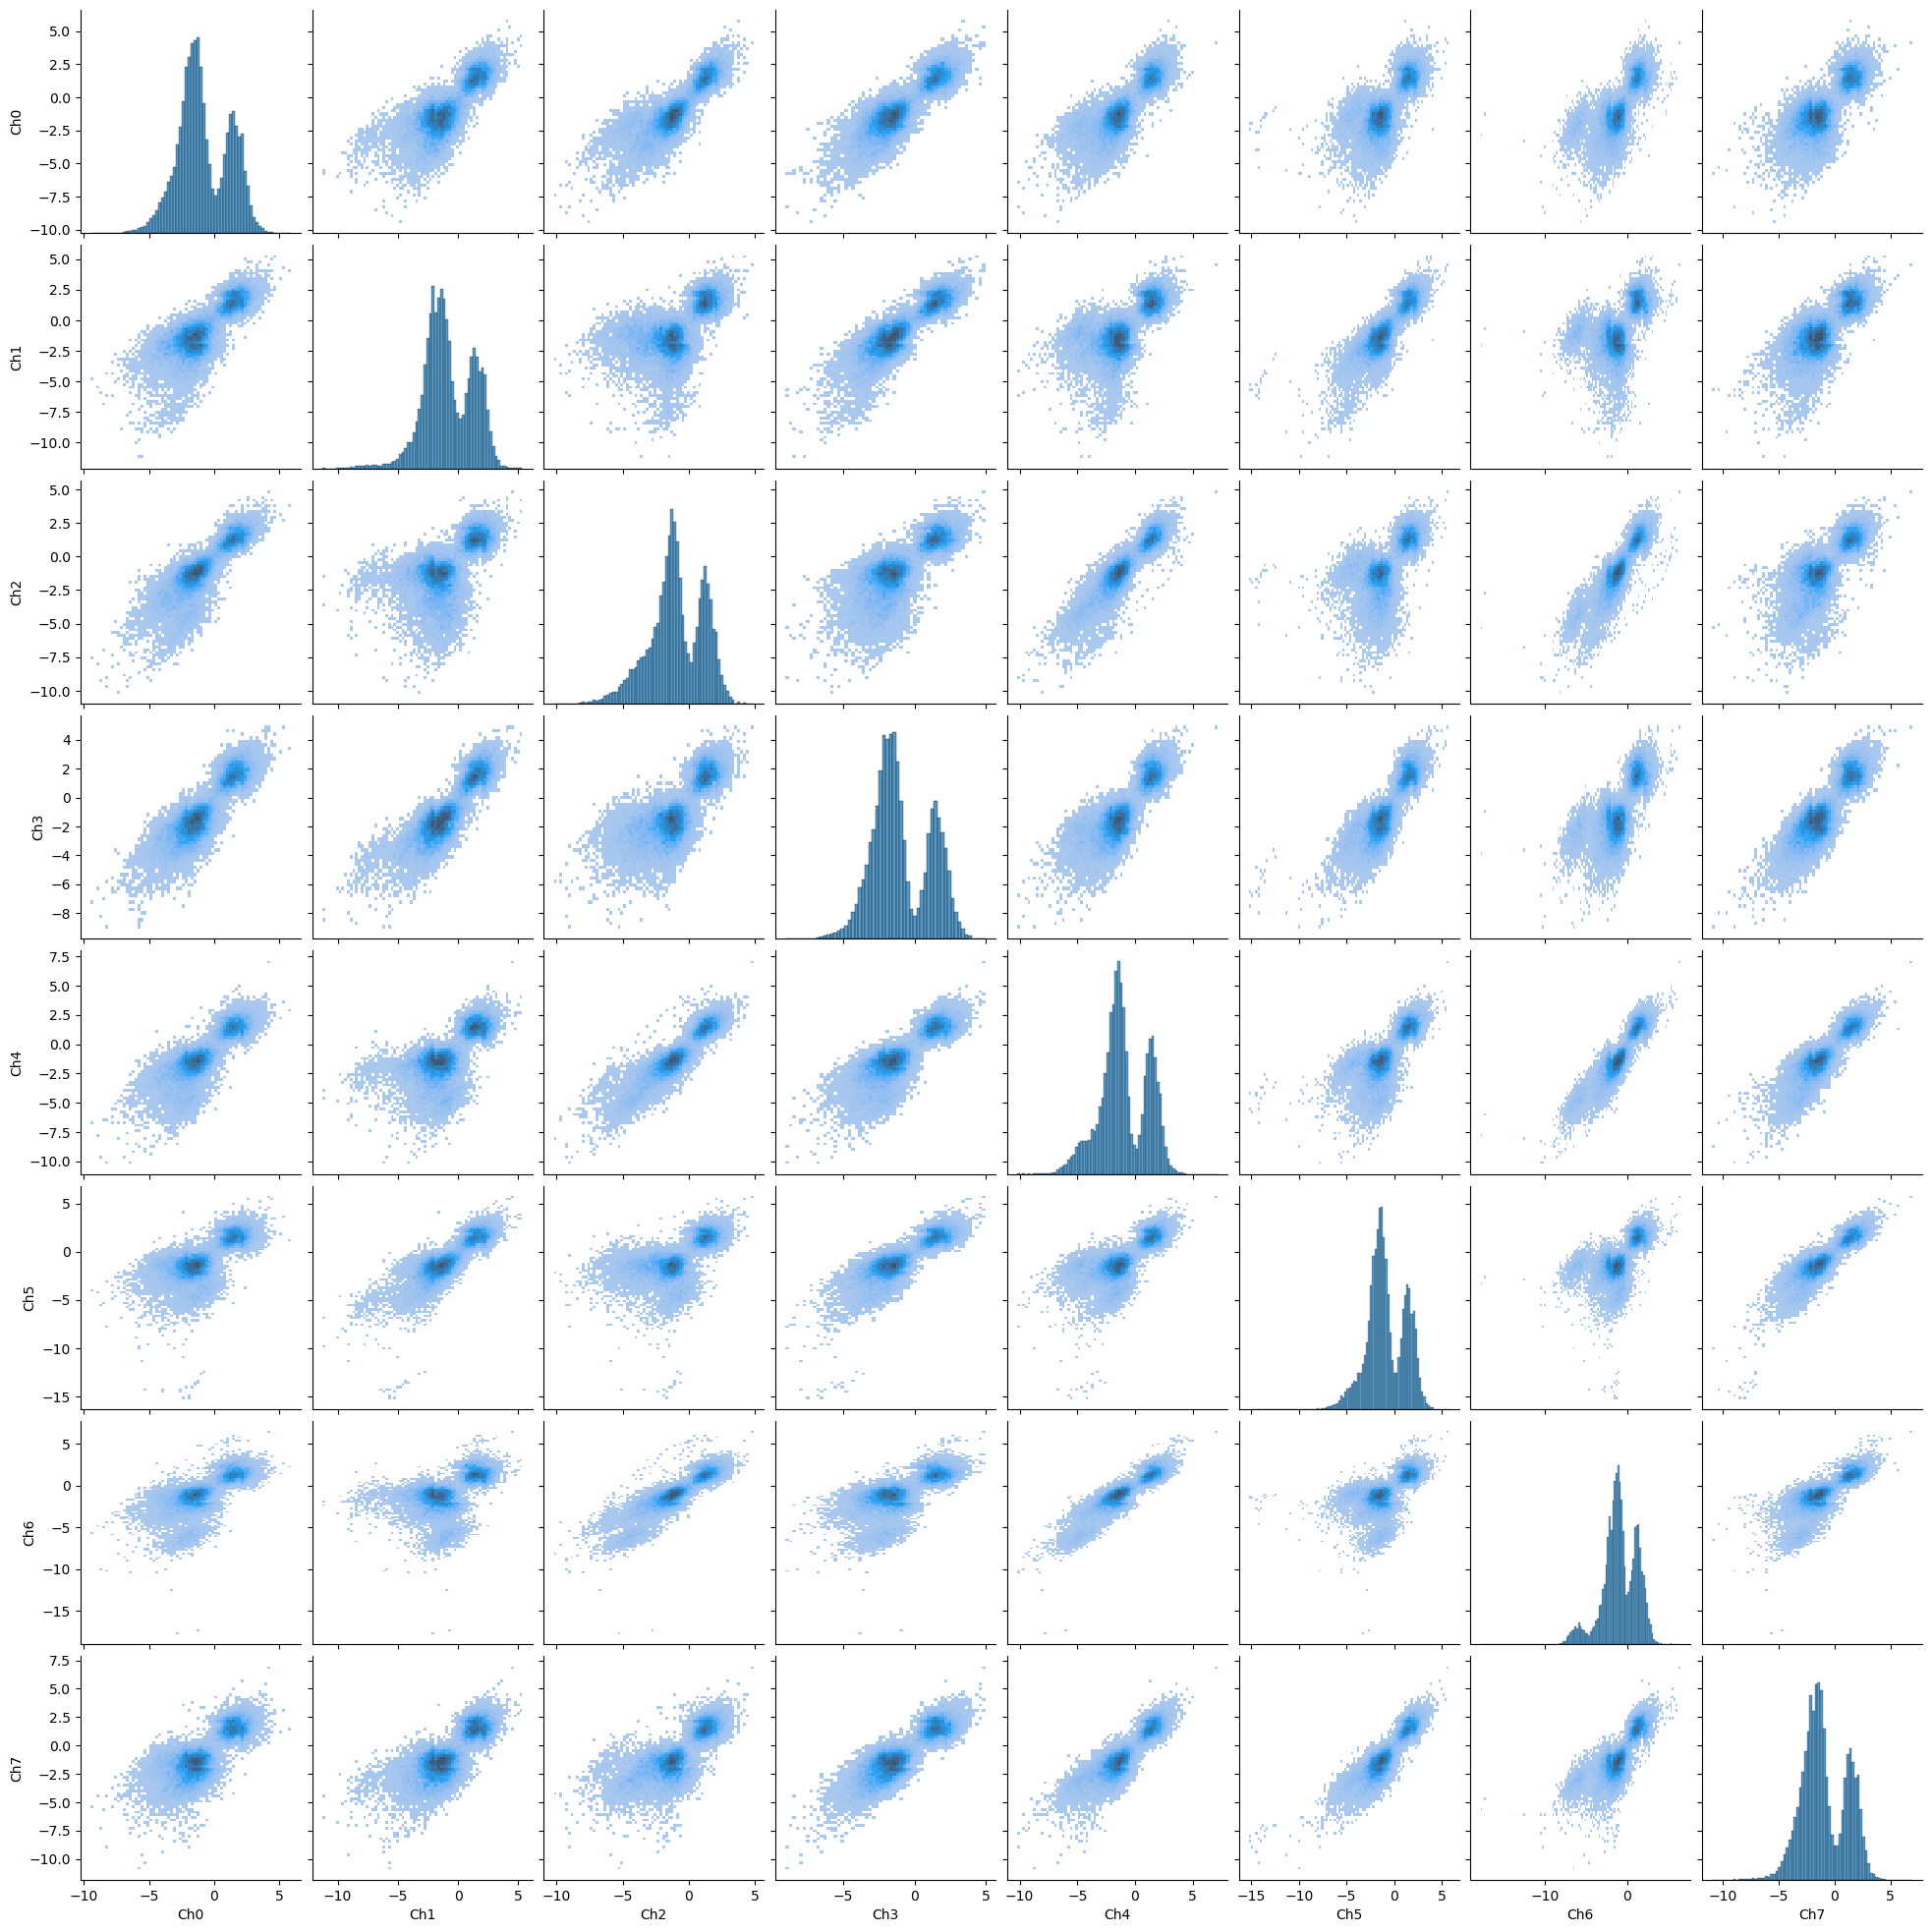

In [24]:
waves_peak_df = pd.DataFrame(waves_peak, columns=['Ch{chnum}'.format(chnum=x) for x in range(chan_num)])
sns.pairplot(data=waves_peak_df,kind='hist')

A few things are apparent from this plot. First, two major clusters, one reflecting positive peaks and the other negative peaks. Second, peak amplitudes tend to be correlated across channels, so if a spike peak is positive on one channel, it will also be positive on another channel. Lastly, some channel pairs show hints of well defined groupings beyond the two major ones (e.g. Ch6/Ch0 pair).

#### Principal components analysis (PCA)

For our hand crafted features we just used the voltage at the peak. However, this doesn't exploit informationa about the entire spike shape. One way to capture this is to identify features across the entire waveform (components) and score each spike based on that component's contribution. PCA is one way to do this. We can choose how many components to use, but typically one uses the 3 that explain the most variation across all spike waveforms.

Typically, one would run PCA on each channel separately.

In [36]:
# Set PCA parameters
n_comp = 3

# Create PCA object
pca = PCA(n_components=n_comp)

# Apply PCA to each channel separately
pca_chans = [pca.fit_transform(x.squeeze()) for x in np.split(waves, chan_num, axis=2)]

# Recombine components across channels
pca_chans = np.hstack(pca_chans)

Running PCA on each channel leaves us with *number of channels* **X** *number of components* dimensions for each spike. This is still greater than 3 and so difficult to visualize. Below I have chosen a few dimensions and performed a pair plot.

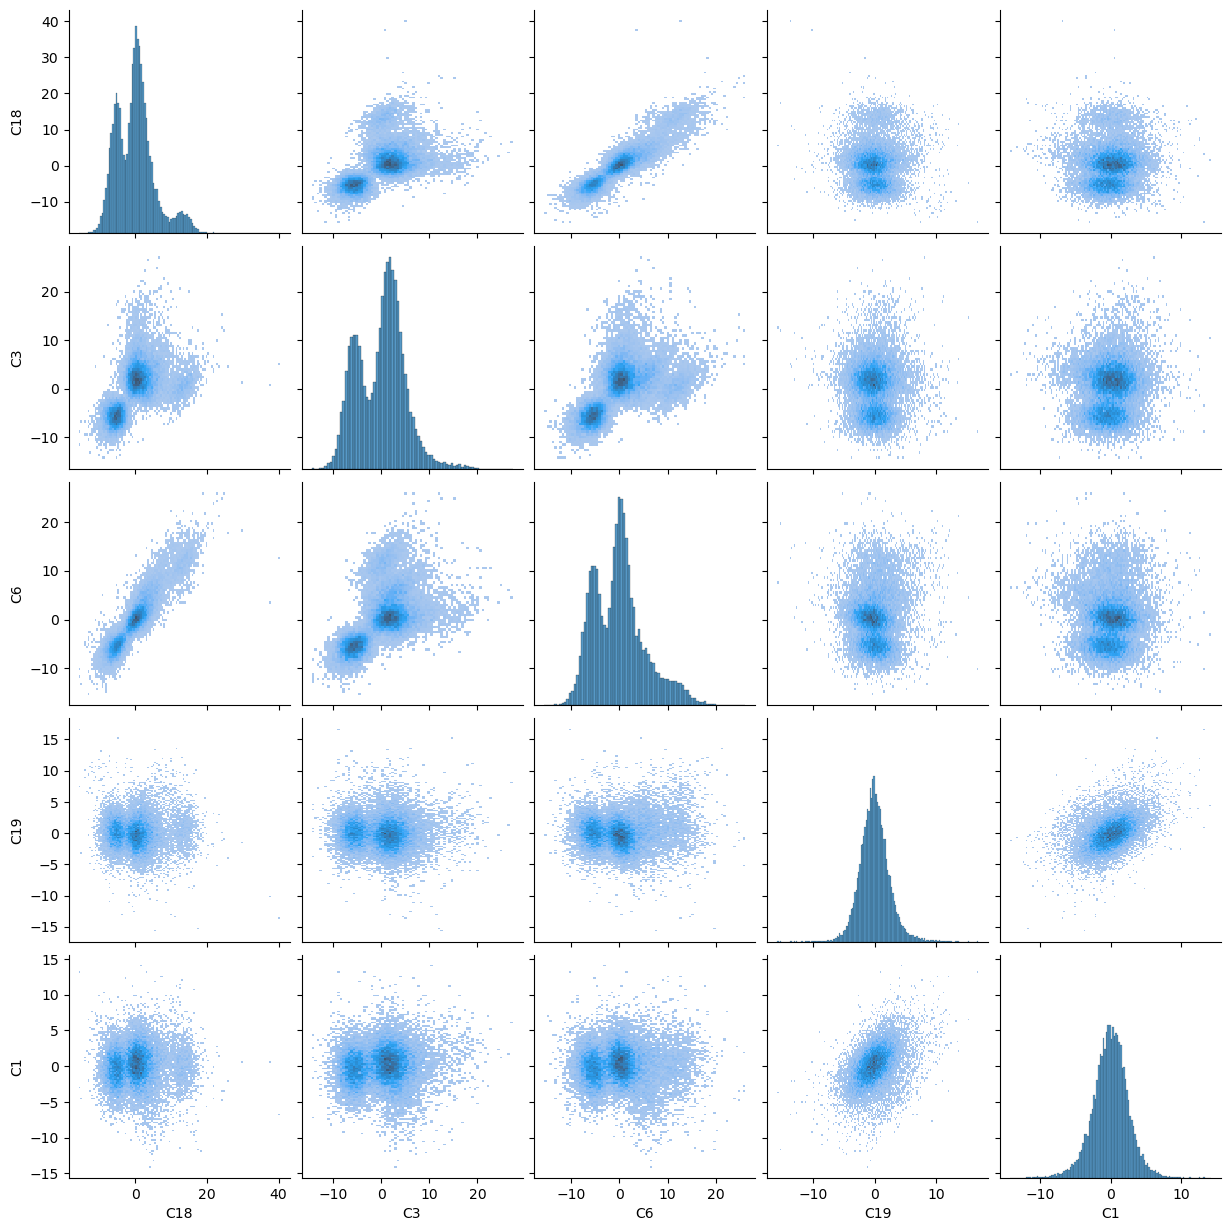

In [127]:
comps = [18,3,6,19,1]
sns.pairplot(pd.DataFrame(pca_chans[:,comps],columns=['C{}'.format(x) for x in comps]),
             kind='hist')

As with the handcrafted features, we can see that positive and negative peaked spikes are separated (the bimodal distributions seen with many of the components). A few other clusters are evident as well, and they are now slightly more distinct compared with the hand crafted features.

It may be that patterns in the spike waveforms spread across multiple channels may better separate different neurons. To determine this, we can have PCA fit components to the entire spike waveform expressed on all channels.

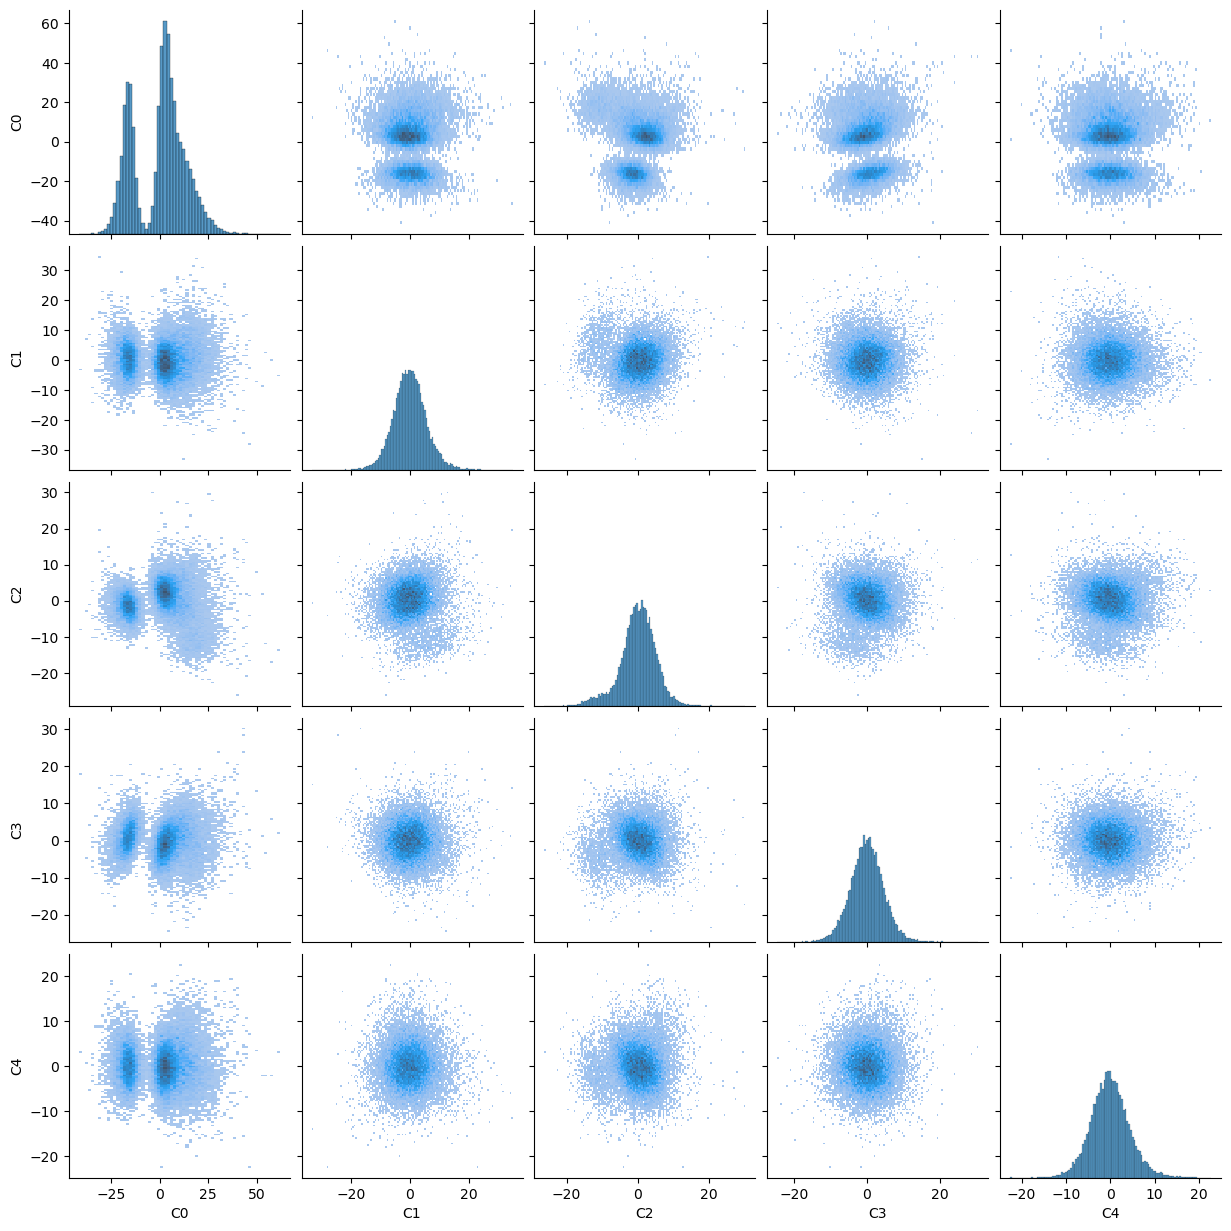

In [75]:
# Set PCA parameters
n_comp = 5

# Create PCA object
pca = PCA(n_components=n_comp)

# Concatenate waveforms across channels for each spike
waves_conc = waves.swapaxes(2,1).reshape((-1,chan_num*win_num))

# Apply PCA to all channels
pca_all = pca.fit_transform(waves_conc)

# Let's plot
sns.pairplot(pd.DataFrame(pca_all, columns=["C{}".format(x) for x in range(n_comp)]), 
             kind='hist')

This did not improve our separation much. Indeed, it is not common to apply PCA on waveforms concatenated across channels.

#### Nonlinear dimensionality reduction techniques

PCA (or its cousin singular value decomposition) continues to be the most common method for distilling spike waveforms to just a few features. Even advanced template matching algorithms, such as Kilosort, use PCA. On the other hand, there has been a growth in algorithms for performing nonlinear dimensionality reduction that may be applicable to the sorting of spike waveforms. While it is not common for them to be used for this purpose, the analytical purpose they serve - transforming high dimensional spaces into lower dimensional ones - is essential what we are trying to do with PCA. In general, these algorithms seek to recapitulate the geometry of a high dimensional space within a lower dimensional one, usually 2 dimensions. This process is sometimes referred to as an *embedding*. We will explore two of them below.

**t-distributed stochastic neighbor embedding (t-SNE)** is a dimensionality reduction technique that converts the distance between each data point into a probability. A lower dimensional space with the same number of data points is also constructed, and the same probability calculation performed. An optimization step then shifts the position of the data points in the lower dimensional space so that the distribution of their probabilities matches that found in the higher dimensional one. This often captures clusterings present in the high dimensional space.

For more details, see: https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

In [139]:
# Parameters for t-SNE
n_comp = 2 # dimensionality of the embedding space
perp = 20 # perplexity, how 'local' are our distance calculations. 

tsne = TSNE(n_components=n_comp, perplexity=perp)

waves_tsne = tsne.fit_transform(waves_conc)

/Users/drewbheadley/opt/anaconda3/envs/spikesort-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/drewbheadley/opt/anaconda3/envs/spikesort-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


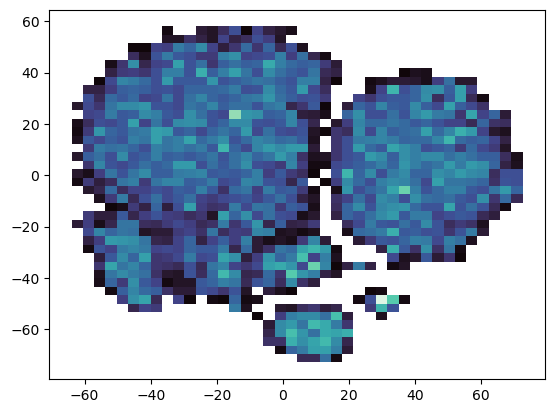

In [140]:
ax = sns.histplot(x=waves_tsne[:,0],y=waves_tsne[:,1],bins=40,cmap='mako')


Here we can see that the two dimensional space that the spike waveforms have been embedded in show more discrete clusters than was present with PCA.

An alternative technique is **uniform manifold approximation and projection (UMAP)**. UMAP attemps to find a high dimensional surface that approximates the distribution of data points, and recreates that in a lower dimensional space. This makes it more sensitive to the global structure of the data, when compared with t-sne.

In [141]:
ured = umap.UMAP()

waves_umap = ured.fit_transform(waves_conc)

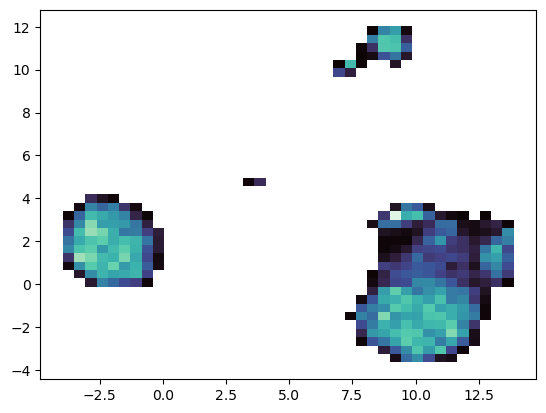

In [142]:
ax = sns.histplot(x=waves_umap[:,0],y=waves_umap[:,1],bins=40,cmap='mako')

UMAP seems to provide much better grouping of waveforms, so we will use it for the classification step next.

### Clustering of spike groups

Once the spike waveforms have been dimensionally reduced in a way to produce clusters, we can classify individual spikes based on which cluster they most likely below two. There are three often used approaches to this. The first is to draw boundaries around clusters by hand. This *manual* step can either be done as the only approach, or after automated cluster assignment as a way to refine and fix errors in an automated approach. The other two approaches are automated. The second is to find the center (also known as a centroid) of each cluster and assign spikes to whichever center they are closet to. The k-means algorithm does this. A third approach is to fit a collection of gaussian probability distributions to the data, and spikes are assinged guassian they are most likely to belong to.

We will skip the manual step because it is self-explanetory and cumbersome to implement in a Jupyter notebook.

#### K-means

K-means clustering assigns each neuron to a cluster based on its closeness to a center point. This results in cluster boundaries that are straight lines, which may not be advantageous in some cases. The experimenter specifies the number of clusters to be used, and will adjust this based on how well the cluster borders match the distribution of data points evident by eye. Note, however, that automated approaches are available to select the number of clusters.

<AxesSubplot: >

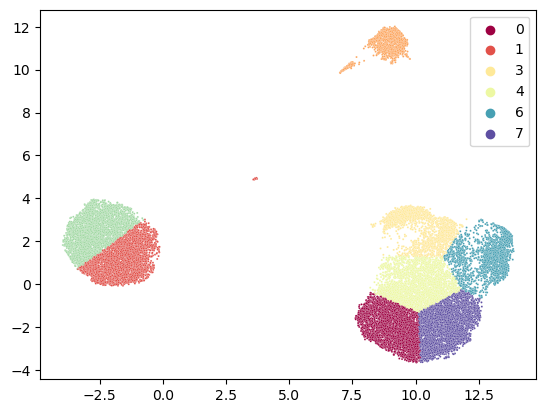

In [147]:
# k-means clustering parameters
n_clus = 8

# fit k-means
km = KMeans(n_clus)
clus_km = km.fit(waves_umap).labels_

# plot clusters
sns.scatterplot(x=waves_umap[:,0],y=waves_umap[:,1],hue=clus_km,palette='Spectral',s=2)

Each spike is a point on the scatter plot, and some of the groups have been over-split. This suggests that we should use a fewer number of clusters.

<AxesSubplot: >

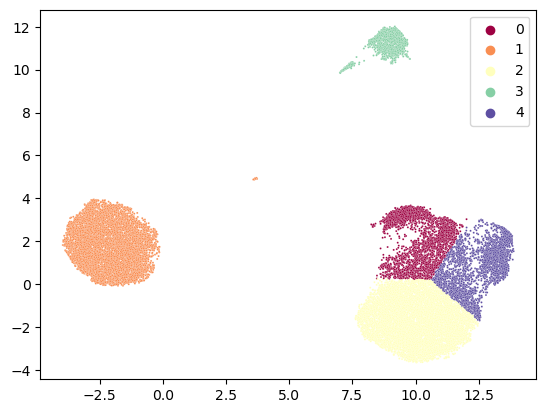

In [148]:
# k-means clustering parameters
n_clus = 5

# fit k-means
km = KMeans(n_clus)
clus_km = km.fit(waves_umap).labels_

# plot clusters
sns.scatterplot(x=waves_umap[:,0],y=waves_umap[:,1],hue=clus_km,palette='Spectral',s=2)

This is better, but note that some clusters appear to include data points outside their visually obvious boundaries.

#### Probabilistic gaussian mixtures

<AxesSubplot: >

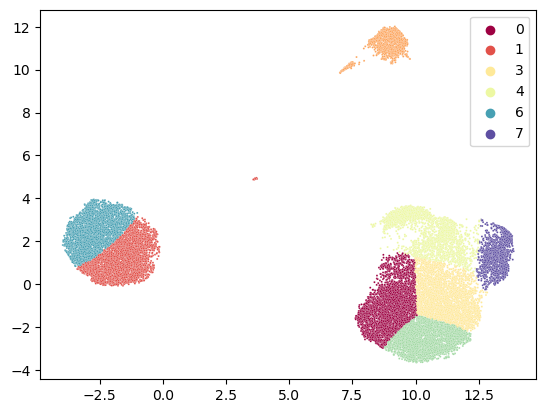

In [151]:
# parameters for gaussian mixture fitting
n_clus = 8

# fit gaussian mixture
gm = GaussianMixture(n_components=n_clus)
gm_mdl = gm.fit(waves_umap)

# cluster by assigning each spike to the gaussian it has the highest probability
# of belonging to
clus_gm = gm_mdl.predict(waves_umap)

# plot clusters
sns.scatterplot(x=waves_umap[:,0],y=waves_umap[:,1],hue=clus_gm,palette='Spectral',s=2)

Note that these cluster boundaries now have curved lines, and are slightly better than the k-means case. But, they are still over-clustered. Let's fix that by lowering the number of clusters.

<AxesSubplot: >

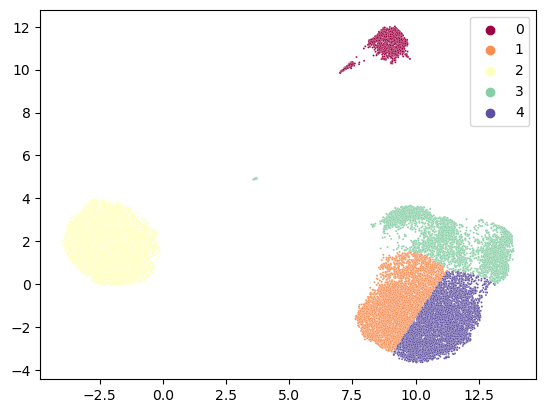

In [155]:
# parameters for gaussian mixture fitting
n_clus = 5

# fit gaussian mixture
gm = GaussianMixture(n_components=n_clus)
gm_mdl = gm.fit(waves_umap)

# cluster by assigning each spike to the gaussian it has the highest probability
# of belonging to
clus_gm = gm_mdl.predict(waves_umap)

# plot clusters
sns.scatterplot(x=waves_umap[:,0],y=waves_umap[:,1],hue=clus_gm,palette='Spectral',s=2)

Not perfect, but better than the k-means case. Usually one would set the number of clusters high, and then use manual refinement to merge clusters that belong together.

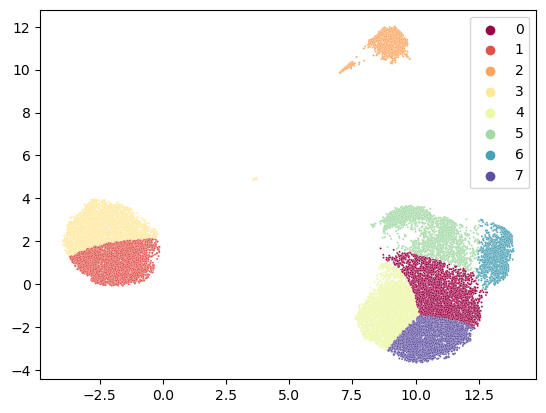

In [166]:
# parameters for gaussian mixture fitting
n_clus = 8

# fit gaussian mixture
gm = GaussianMixture(n_components=n_clus,random_state=0)
gm_mdl = gm.fit(waves_umap)

# cluster by assigning each spike to the gaussian it has the highest probability
# of belonging to
clus_gm = gm_mdl.predict(waves_umap)

# plot clusters
ax = sns.scatterplot(x=waves_umap[:,0],y=waves_umap[:,1],hue=clus_gm,
                     palette='Spectral',s=2, legend='full')

It is evident from this that some groups should be merged together. These are 1 & 3, and 4 & 0 & 7.

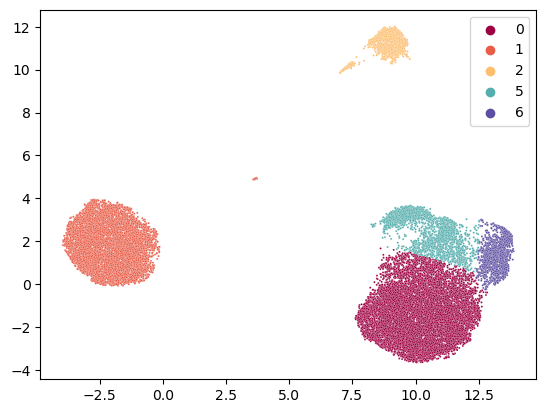

In [174]:
# merge clusters
clus_gm[clus_gm==3] = 1
clus_gm[clus_gm==4] = 0
clus_gm[clus_gm==7] = 0

# replot clusters
ax = sns.scatterplot(x=waves_umap[:,0],y=waves_umap[:,1],hue=clus_gm,
                     palette='Spectral',s=2, legend='full')


With this we can now plot the mean waveform for each cluster.

<AxesSubplot: >

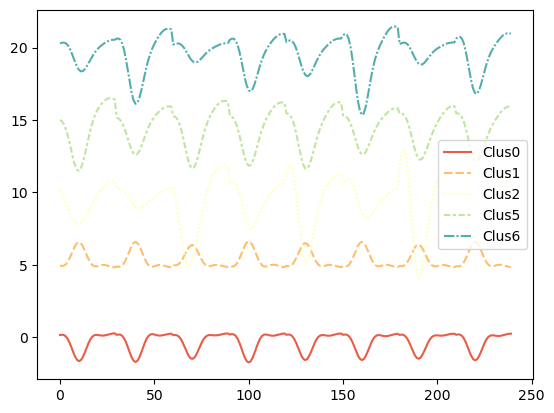

In [181]:
# list of unique clusters
clus_uniq = np.unique(clus_gm)
waves_mean = [waves_conc[clus_gm==x,:].mean(axis=0)+(ind*5) for ind,x in enumerate(clus_uniq)]

waves_mean_df = pd.DataFrame(np.vstack(waves_mean).T,columns=["Clus{}".format(x) for x in clus_uniq])
sns.lineplot(data=waves_mean_df,palette='Spectral', legend='full')

In all likelihood, clusters 2 and 6 are single units, while the remainders are distant multi-units. 